In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np 
import pandas as pd 
import seaborn as sns

from sklearn.metrics import mean_squared_error

import os

In [2]:
import scipy.stats as scs

In [3]:
import statsmodels.api as sm

C:\Users\Sladkish\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:49: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


In [4]:
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt

In [5]:
Path_Energy ='my_PJME_MW.csv'

In [6]:
data = pd.read_csv(Path_Energy, index_col=[0], parse_dates=[0])
data.head()

,Time,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,hour,is_holiday,is_prev_holiday,is_next_holiday
Date,,,,,,,,,,,,,
2002-01-01,01:00:00,30393.0,2002,1,1,1,1,1,1,1,1,0,0
2002-01-01,02:00:00,29265.0,2002,1,1,1,1,1,1,2,1,0,0
2002-01-01,03:00:00,28357.0,2002,1,1,1,1,1,1,3,1,0,0
2002-01-01,04:00:00,27899.0,2002,1,1,1,1,1,1,4,1,0,0
2002-01-01,05:00:00,28057.0,2002,1,1,1,1,1,1,5,1,0,0


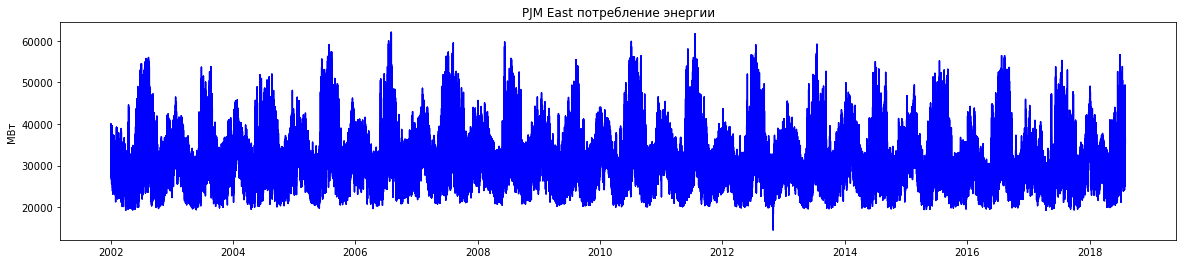

In [7]:
plt.figure(figsize =(20,4))
plt.plot( data.index, data['PJME_MW'], 'b' )
plt.title('PJM East потребление энергии' )
plt.ylabel ( 'МВт' )
plt.show()

In [8]:
data_m = data.resample('M').mean()

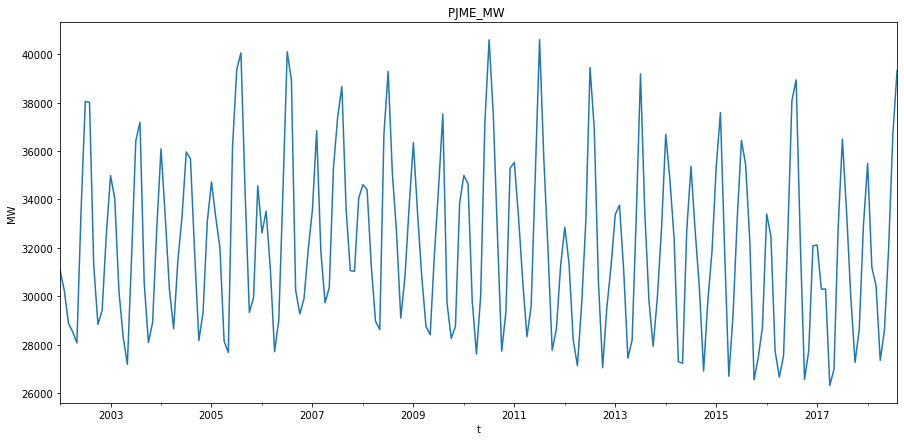

In [9]:
d_data = data['PJME_MW'].values[1:]-data['PJME_MW'].values[:-1]
_ = data_m['PJME_MW'].plot( style='-', figsize=( 15, 7 ), title='PJME_MW ')
plt.ylabel('MW')
plt.xlabel('t')
plt.show()

Вывод ряд по потреблению энергии похож на стационарный

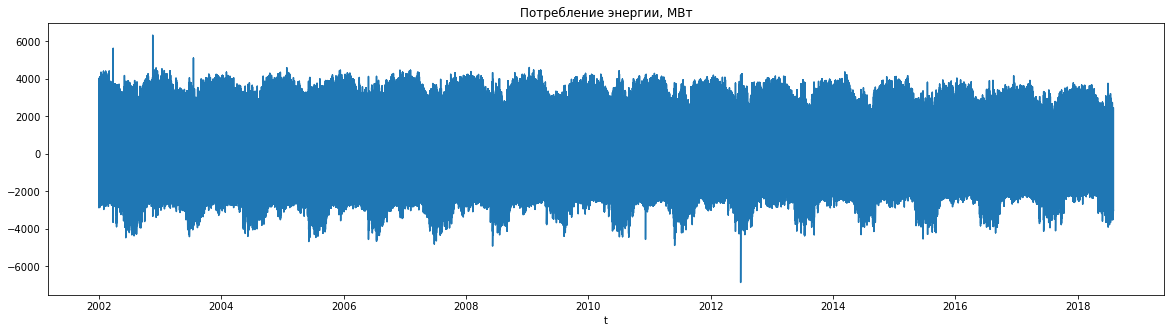

In [10]:
plt.figure(figsize=(20,5))
plt.plot(data.iloc[:-1].index,d_data)
plt.xlabel('t')
plt.title('Потребление энергии, МВт')
plt.show()

Вывод: такая разность выглядит не совсем стационарно

In [11]:
DF_data = sm.tsa.stattools.adfuller(data_m['PJME_MW'].values[:100],regression='ct')
DF_data

(-0.9879271614271755,
 0.945717945461718,
 11,
 88,
 {'1%': -4.065513968057382,
  '5%': -3.4616143302732905,
  '10%': -3.156971502864388},
 1540.9733442182637)

In [12]:
DF_data = sm.tsa.stattools.adfuller(data_m['PJME_MW'].values,regression='ctt')
DF_data

(-2.5774555917298194,
 0.5247860093675522,
 15,
 184,
 {'1%': -4.435220952056536,
  '5%': -3.86487409876613,
  '10%': -3.5733156719443473},
 3230.9060995689206)

месячные средние по потреблению энергию не являются стационарными. Проверим первые разности на стационарность.

In [13]:
DF_data_d = sm.tsa.stattools.adfuller(d_data,regression='ct')
print('коэффициент ADF для 1-й разности потребления энергии: ', DF_data_d[1])


коэффициент ADF для 1-й разности потребления энергии:  0.0


Получили стационарный ряд, а на основании этого теста наши ряды называют **интегрированным рядом**, т.е.  лаги изменения потребления энергии стационарны на месячных интервалах.

Это говорит о том, что нужно разделить модель на отдельные составляющие - сезонность у потребления энергии  от стационарных колебаний вокруг этих компонент.

In [14]:
# data_ar = data['PJME_MW'].values

In [15]:
data_s = pd.DataFrame(data = data['PJME_MW'])

In [16]:
N2 = 24*7

In [17]:
def exponential_smoothing(series, alpha):
    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

In [18]:
d_data=data.resample('D').mean()


Text(0.5, 1.0, 'PJME_MW')

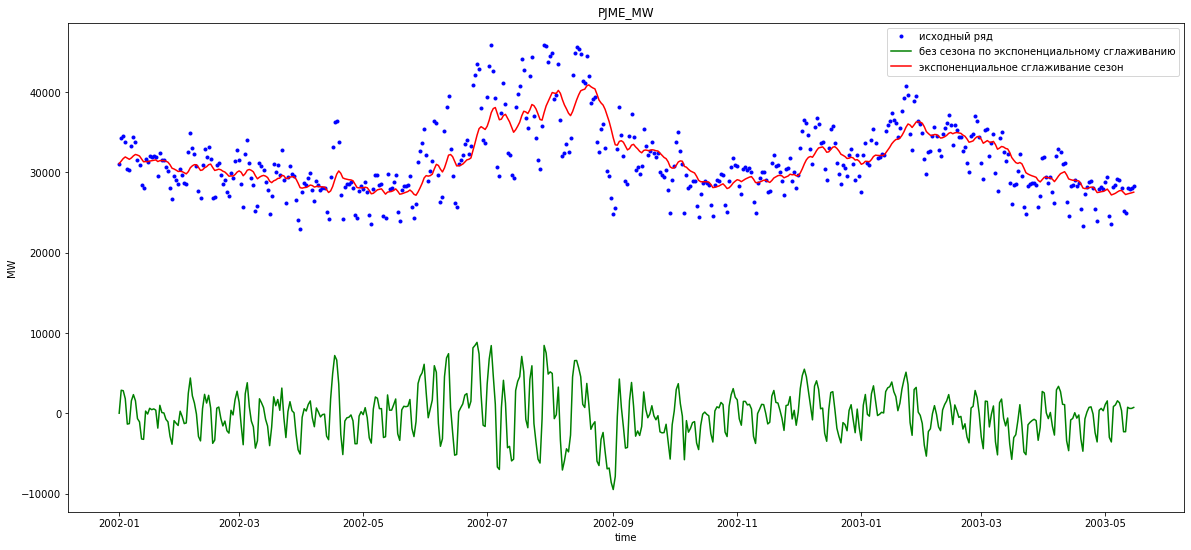

In [19]:
data_exp_1 = exponential_smoothing(d_data['PJME_MW'], 0.1)
plt.figure(figsize=(20, 9))
plt.plot(d_data.index[:500], d_data['PJME_MW'].values[:500], '.b',label='исходный ряд')

plt.plot(d_data.index[:500],d_data['PJME_MW'].values[:500] - data_exp_1[:500] , color = 'green', label="без сезона по экспоненциальному сглаживанию");

plt.plot(d_data.index[:500],data_exp_1[:500] , color = 'red', label="экспоненциальное сглаживание сезон");

plt.xlabel('time')
plt.ylabel('MW')
plt.legend()
plt.title('PJME_MW')




In [20]:
data_seson_free = pd.DataFrame(data = (np.array(d_data['PJME_MW']).reshape((d_data['PJME_MW'].shape[0],1)) -data_exp_1))
DF_ = sm.tsa.stattools.adfuller( data_seson_free.iloc[:,0] , regression = 'ctt')
DF_

(-8.365362138561911,
 4.2829746153965626e-11,
 34,
 6024,
 {'1%': -4.373054660566805,
  '5%': -3.833370706612336,
  '10%': -3.55386764946938},
 107622.59914749119)

В соответствии с тестом ADF - это стационарный ряд

In [21]:
data_seson_free = pd.DataFrame(data = (np.array(d_data['PJME_MW']).reshape((d_data['PJME_MW'].shape[0],1)) -data_exp_1))
DF_ = sm.tsa.stattools.adfuller( data_seson_free.iloc[:,0] , regression = 'ctt')
DF_

(-8.365362138561911,
 4.2829746153965626e-11,
 34,
 6024,
 {'1%': -4.373054660566805,
  '5%': -3.833370706612336,
  '10%': -3.55386764946938},
 107622.59914749119)

In [22]:
d_data_s=data_s.resample('D').mean()
d_data_s.head()

,PJME_MW
Date,
2002-01-01,31080.739130
2002-01-02,34261.541667
2002-01-03,34511.875000
2002-01-04,33715.458333
2002-01-05,30405.125000


In [23]:
data_exp_1 = pd.DataFrame(data = data_exp_1, index = d_data.index)
data_exp_1.head()

,0
Date,
2002-01-01,31080.739130
2002-01-02,31398.819384
2002-01-03,31710.124946
2002-01-04,31910.658284
2002-01-05,31760.104956


In [24]:
df= data_exp_1
df.head()
 # добавили историю на глубину 3 измерения от текущего (р=3)
df['t'] = 0.0
df.iloc[1:,1]=df.iloc[:-1,0].values
df['t1']=0.0
df.iloc[2:,2]=df.iloc[:-2,0].values
df['t2']=0.0
df.iloc[3:,3]=df.iloc[:-3,0].values
df.fillna(0)
# добавили сглаживание (3 вида - просто для коллекции)
df['exp_0_01'] = exponential_smoothing(df[0], 0.01)
df['exp_0_03'] = exponential_smoothing(df[0], 0.03)
df['exp_0_08'] = exponential_smoothing(df[0], 0.08)
# добавим разности - 1-й порядок
df['diff1'] = 0.0
df['diff1'].iloc[1:] = df.iloc[:-1,0].values-df.iloc[1:,0].values
df.head()

,0,t,t1,t2,exp_0_01,exp_0_03,exp_0_08,diff1
Date,,,,,,,,
2002-01-01,31080.739130,0.000000,0.000000,0.000000,31080.739130,31080.739130,31080.739130,0.000000
2002-01-02,31398.819384,31080.739130,0.000000,0.000000,31083.919933,31090.281538,31106.185551,-318.080254
2002-01-03,31710.124946,31398.819384,31080.739130,0.000000,31090.181983,31108.876840,31154.500702,-311.305562
2002-01-04,31910.658284,31710.124946,31398.819384,31080.739130,31098.386746,31132.930284,31214.993309,-200.533339
2002-01-05,31760.104956,31910.658284,31710.124946,31398.819384,31105.003928,31151.745524,31258.602241,150.553328


In [25]:
df.columns

Index([0, 't', 't1', 't2', 'exp_0_01', 'exp_0_03', 'exp_0_08', 'diff1'], dtype='object')

In [26]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import mean_absolute_error, mean_squared_error, median_absolute_error, r2_score
scl =StandardScaler()
scly =StandardScaler()




In [27]:
def split_data( data, split_date ):
    return data.loc[data.index.get_level_values('Date') <= split_date].copy(), \
           data.loc[data.index.get_level_values('Date') >  split_date].copy()

In [28]:
train, test = split_data( df, '01-06-2016')
X_train = train.iloc[:-1,:]
y_train = train[df.columns[0]].values[1:]
X_test = test.iloc[:-1,:]
y_test = test[df.columns[0]].values[1:]

In [29]:
len(train), len(test)

(5119, 940)

In [30]:
len(X_train), len(X_test)

(5118, 939)

In [31]:
len(y_train), len(y_test)

(5118, 939)

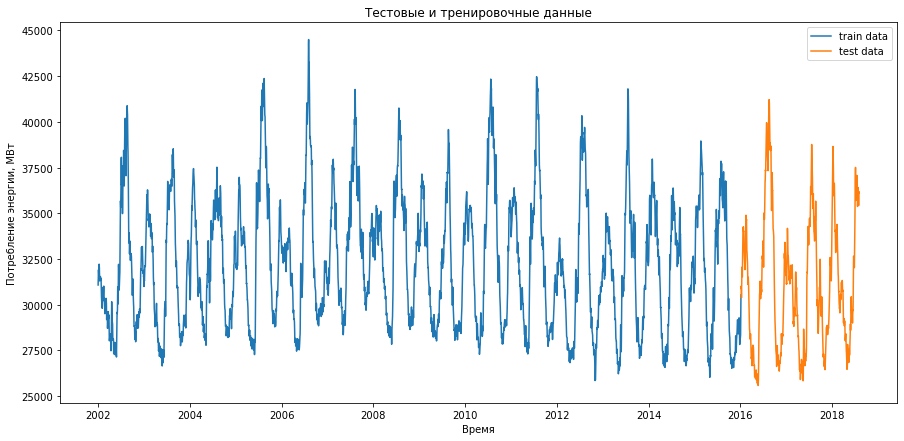

In [32]:
plt.figure( figsize=( 15, 7 ))
plt.xlabel('Время')
plt.ylabel('Потребление энергии, МВт')
plt.plot(train.index.get_level_values('Date'), train[df.columns[0]], label='train data' )
plt.plot(test.index.get_level_values('Date'), test[df.columns[0]], label='test data')
plt.title( 'Тестовые и тренировочные данные' )
plt.legend()
plt.show()

In [33]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


In [34]:
model_gb = GradientBoostingRegressor(max_depth=10, random_state=42, n_estimators=100)

In [35]:
model_gb.fit( X_train, y_train )

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=10, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, n_iter_no_change=None, presort='auto',
             random_state=42, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

In [36]:
X_test_pred_gb = model_gb.predict(X_test)


In [37]:
len(X_test_pred_gb)

939

In [38]:
 df.loc['01-06-2016':].index[:]

DatetimeIndex(['2016-01-06', '2016-01-07', '2016-01-08', '2016-01-09',
               '2016-01-10', '2016-01-11', '2016-01-12', '2016-01-13',
               '2016-01-14', '2016-01-15',
               ...
               '2018-07-25', '2018-07-26', '2018-07-27', '2018-07-28',
               '2018-07-29', '2018-07-30', '2018-07-31', '2018-08-01',
               '2018-08-02', '2018-08-03'],
              dtype='datetime64[ns]', name='Date', length=941, freq='D')

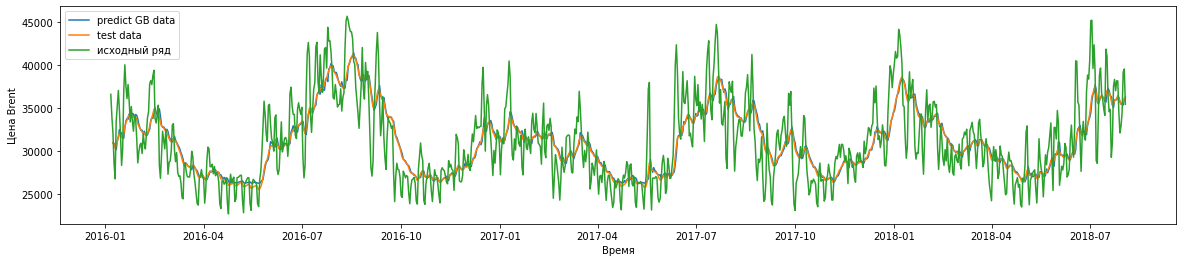

ошибка градиентного бустинга :   0.7080383220145594 %


In [39]:
plt.figure( figsize=( 20, 4 ))
plt.xlabel('Время')
plt.ylabel('Цена Brent')
plt.plot(test.index[1:],X_test_pred_gb, label='predict GB data' )
plt.plot(test.index[1:],y_test, label='test data')
plt.plot(d_data_s.loc['01-06-2016':].index, d_data_s.loc['01-06-2016':]['PJME_MW'], label='исходный ряд')
plt.legend()
plt.show()

er_g = mean_absolute_percentage_error(y_true=y_test, y_pred=X_test_pred_gb)

print('ошибка градиентного бустинга :  ', er_g, '%')

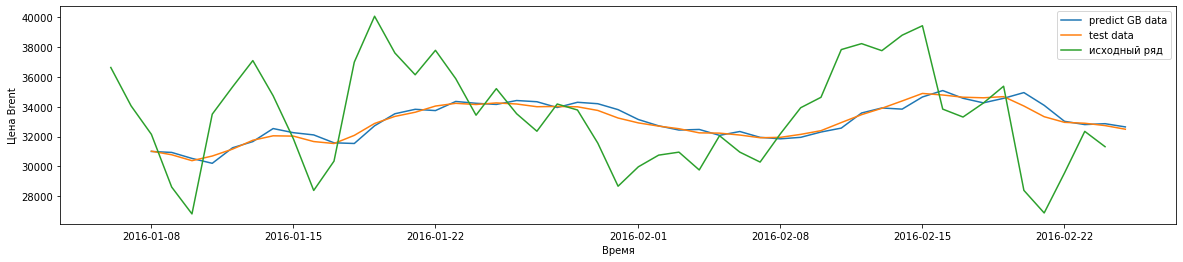

ошибка градиентного бустинга :   0.7080383220145594 %


In [40]:
plt.figure( figsize=( 20, 4 ))
plt.xlabel('Время')
plt.ylabel('Цена Brent')
plt.plot(test.index[1:50],X_test_pred_gb[:49], label='predict GB data' )
plt.plot(test.index[1:50],y_test[:49], label='test data')
plt.plot(d_data_s.loc['01-06-2016':].index[:50], d_data_s.loc['01-06-2016':]['PJME_MW'].values[:50], label='исходный ряд')
plt.legend()
plt.show()

er_g = mean_absolute_percentage_error(y_true=y_test, y_pred=X_test_pred_gb)

print('ошибка градиентного бустинга :  ', er_g, '%')

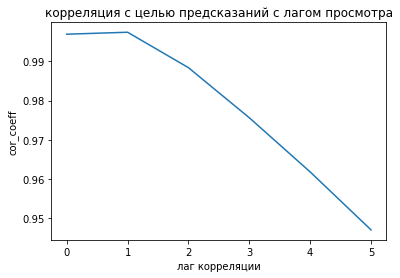

In [41]:
lag=5
p_cor=[np.corrcoef( y_test, X_test_pred_gb)[1,0]]
for i in range(lag):
    c=np.corrcoef( y_test[:-(i+1)], X_test_pred_gb[(i+1):])[1,0]
    p_cor.append(c)    

plt.plot(np.array(p_cor) ) 
plt.xlabel('лаг корреляции')
plt.ylabel('cor_coeff')
plt.title('корреляция с целью предсказаний с лагом просмотра')
plt.show()

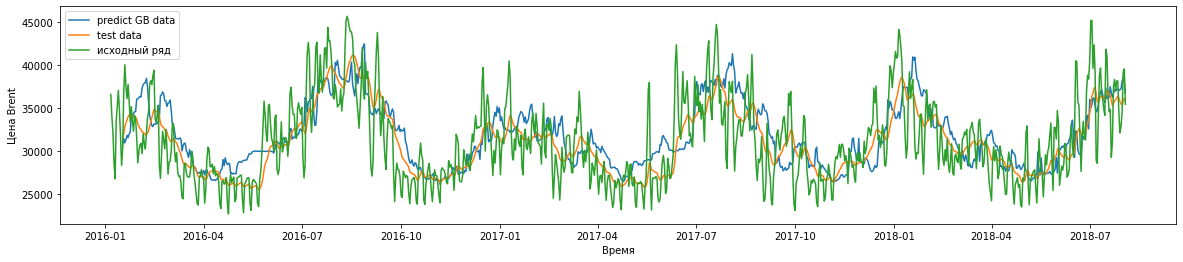

ошибка градиентного бустинга :   5.137566511051342 %


In [42]:
h=10
X_train = train.iloc[:-h,:]
y_train = train[df.columns[0]].values[h:]
X_test = test.iloc[:-h,:]
y_test = test[df.columns[0]].values[h:]

model_gb.fit( X_train, y_train ) 
X_test_pred_gb = model_gb.predict(X_test)

plt.figure( figsize=( 20, 4 ))

plt.xlabel('Время')
plt.ylabel('Цена Brent')
plt.plot(test.index[h:],X_test_pred_gb, label='predict GB data' )
plt.plot(test.index[h:],y_test, label='test data')
plt.plot(d_data_s.loc['01-06-2016':].index, d_data_s.loc['01-06-2016':]['PJME_MW'], label='исходный ряд')

plt.legend()
plt.show()

er_g = mean_absolute_percentage_error(y_true=y_test, y_pred=X_test_pred_gb)

print('ошибка градиентного бустинга :  ', er_g, '%')

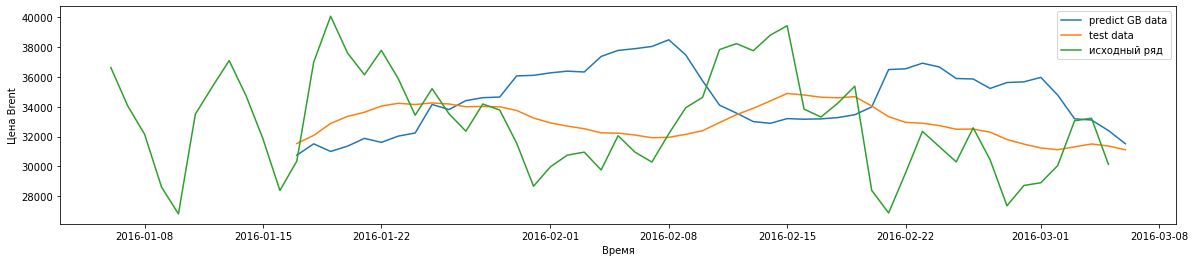

ошибка градиентного бустинга :   5.137566511051342 %


In [43]:
plt.figure( figsize=( 20, 4 ))
plt.xlabel('Время')
plt.ylabel('Цена Brent')
plt.plot(test.index[h:60],X_test_pred_gb[:60-h], label='predict GB data' )
plt.plot(test.index[h:60],y_test[:60-h], label='test data')
# # plt.plot(b_s.loc['2018-11-02':].index, b_s.loc['2018-11-02':]['Значение'], label='исходный ряд')
plt.plot(d_data_s.loc['01-06-2016':].index[:60], d_data_s.loc['01-06-2016':]['PJME_MW'].values[:60], label='исходный ряд')

plt.legend()
plt.show()

er_g = mean_absolute_percentage_error(y_true=y_test, y_pred=X_test_pred_gb)

print('ошибка градиентного бустинга :  ', er_g, '%')

Прочитайте базу "Потребление Энергии" и сделайте модель для сезонных изменений по data_exp_1 с глубиной прогноза h=1 и h=10 по образцу из примера для обработки ряда "цена Нефти" .

Оцените ошибку модели из п.1 .




#### Вывод: Модель авторегрессии с горизонтом прогноза 1 хорошо работает замечательно на всем интервале теста. Значение ошибки для нее не превышает 0.7%.

Сделайте вывод о том, как изменилась ошибка модели по значениям h.

#### Вывод: в моем случае ошибка увеличилась
    

Попробуйте предположить характер ряда (стационарный или нет, с трендом, с сезоном, с циклом) для рядов из списка и аргументируйте свой ответ (одна строка):

а) Изменение температуры за окном :).


а) Будет присутвовать сезоннасть. В течении сезона мы сможем наблюдать не постаянную дисперсию и постоянное среднее значение тмпературы. 

б) Количество денег, которые тратят покупатели в интернет магазине.

б) Здесь будет тренд. Перед празниками будет наблюдаться повышение покупок, а после праздников спад. Это не стационарный ряд

в) Вес растущего котенка.

в)  растущий котенок, очевидно, имеет тренд и увеличивается в размерах. Это не стационарный ряд

г) Прирост объема деревьев в лесу от времени

г)  Имеем тренд, увелечение объема деревьев. Это не стационарный ряд